 ![GDP](image/GDP.png)
# **GDP Forecast in The United States**

Gross Domestic Product (GDP)  is critical indicator of the economic health and stability of the United States. GDP measures the total value of goods and services produced, representing overall economic growth. Historically, the U.S. economy has experienced robust growth, with occasional recessions—such as the 2008 financial crisis and the COVID-19 pandemic—that temporarily disrupted GDP growth. 

For this project, the datasets were sourced from the  Federal Reserve Economic Data. 

### CRISP-DM Framework for Forecasting
We follow the CRISP-DM (Cross-Industry Standard Process for Data Mining) framework, a widely used methodology, to predict inflation. The phases are:
1.	Business Understanding: Forecast inflation rates for different countries and identify key features influencing inflation.
2.	Data Understanding: Analyze World Bank datasets on inflation.
3.	Data Preparation: Clean and preprocess the data for analysis.
4.	Modeling: Build and test models for forecasting.
5.	Evaluation: Assess model performance.
6.	Deployment: Implement the model for future forecasts.

 
 ![CRISP-DM](image/pic2.png)

 

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.arima.model import ARIMA


## Data Understanding

In [11]:

# Load the datasets
cpi_data = pd.read_csv('data2/CPIAUCSL.csv')
dff_data = pd.read_csv('data2/DFF.csv')
fedfunds_data = pd.read_csv('data2/FEDFUNDS.csv')
gdp_data = pd.read_csv('data2/GDP.csv')
indpro_data = pd.read_csv('data2/INDPRO.csv')
unrate_data = pd.read_csv('data2/UNRATE.csv')

# Display the first few rows of each dataset to understand their structure
datasets = {
    'CPIAUCSL': cpi_data.head(),
    'DFF': dff_data.head(),
    'FEDFUNDS': fedfunds_data.head(),
    'GDP': gdp_data.head(),
    'INDPRO': indpro_data.head(),
    'UNRATE': unrate_data.head()
}

datasets


{'CPIAUCSL':        DATE  CPIAUCSL
 0  1/1/1960     29.37
 1  2/1/1960     29.41
 2  3/1/1960     29.41
 3  4/1/1960     29.54
 4  5/1/1960     29.57,
 'DFF':      DATE  DFF
 0  1/1/60  4.0
 1  1/2/60  4.0
 2  1/3/60  4.0
 3  1/4/60  4.0
 4  1/5/60  4.0,
 'FEDFUNDS':        DATE  FEDFUNDS
 0  1/1/1960      3.99
 1  2/1/1960      3.97
 2  3/1/1960      3.84
 3  4/1/1960      3.92
 4  5/1/1960      3.85,
 'GDP':         DATE      GDP
 0   1/1/1960  542.648
 1   4/1/1960  541.080
 2   7/1/1960  545.604
 3  10/1/1960  540.197
 4   1/1/1961  545.018,
 'INDPRO':        DATE   INDPRO
 0  1/1/1960  24.1658
 1  2/1/1960  23.9508
 2  3/1/1960  23.7357
 3  4/1/1960  23.5476
 4  5/1/1960  23.5207,
 'UNRATE':        DATE  UNRATE
 0  1/1/1960     5.2
 1  2/1/1960     4.8
 2  3/1/1960     5.4
 3  4/1/1960     5.2
 4  5/1/1960     5.1}

In [4]:

#Adjust the dates manually, treating all years between '00' and '69' as 1900s
dff_data['DATE'] = pd.to_datetime(dff_data['DATE'], format='%m/%d/%y')

# Check for years misinterpreted as 2060 and beyond, then correct them
#dff_data['DATE'] = dff_data['DATE'].apply(lambda x: x if x.year < 2060 else x.replace(year=x.year - 100))




In [5]:
#Aggregate the daily data of DFF to monthly(first day of the month)
# Convert the 'DATE' column to datetime format for easier manipulation
#dff_data['DATE'] = pd.to_datetime(dff_data['DATE'], format='%m/%d/%y')


# Drop the existing 'DATE' column when resetting the index to avoid conflict
df_monthly = dff_data.groupby(dff_data['DATE'].dt.to_period('M')).first().reset_index(drop=True)

df_monthly.head()


,DATE,DFF
0,1969-01-01,4.00
1,1969-02-01,6.38
2,1969-03-01,7.00
3,1969-04-01,6.63
4,1969-05-01,8.25


In [6]:
# Ensure all DATE columns are in datetime format, DFF is already taken care of.
cpi_data['DATE'] = pd.to_datetime(cpi_data['DATE'])
fedfunds_data['DATE'] = pd.to_datetime(fedfunds_data['DATE'])
gdp_data['DATE'] = pd.to_datetime(gdp_data['DATE'])
indpro_data['DATE'] = pd.to_datetime(indpro_data['DATE'])
unrate_data['DATE'] = pd.to_datetime(unrate_data['DATE'])


In [7]:
# Taking care of GDP since the data is in quarters and the rest data is monthly
#Populate the data from the quarter to each month


# Convert the 'DATE' column to datetime format for easier manipulation
#gdp_df['DATE'] = pd.to_datetime(gdp_df['DATE'], format='%m/%d/%y')

# Expanding the GDP data to populate all months in the quarter
gdp_data = gdp_data.set_index('DATE').resample('MS').ffill().reset_index()

# Merge with the DFF data
# Now merge the GDP data with the user's DFF dataset
#df_merged = pd.merge(df_monthly_corrected, gdp_df, on='DATE', how='left')

gdp_data.head()


,DATE,GDP
0,1960-01-01,542.648
1,1960-02-01,542.648
2,1960-03-01,542.648
3,1960-04-01,541.080
4,1960-05-01,541.080


In [8]:


# Check the date ranges and frequencies in each dataset
date_ranges = {
    "CPIAUCSL": (cpi_data['DATE'].min(), cpi_data['DATE'].max(), cpi_data['DATE'].diff().value_counts().head()),
    "DFF": (df_monthly['DATE'].min(), df_monthly['DATE'].max(), df_monthly['DATE'].diff().value_counts().head()),
    "FEDFUNDS": (fedfunds_data['DATE'].min(), fedfunds_data['DATE'].max(), fedfunds_data['DATE'].diff().value_counts().head()),
    "GDP": (gdp_data['DATE'].min(), gdp_data['DATE'].max(), gdp_data['DATE'].diff().value_counts().head()),
    "INDPRO": (indpro_data['DATE'].min(), indpro_data['DATE'].max(), indpro_data['DATE'].diff().value_counts().head()),
    "UNRATE": (unrate_data['DATE'].min(), unrate_data['DATE'].max(), unrate_data['DATE'].diff().value_counts().head())
}

date_ranges


{'CPIAUCSL': (Timestamp('1960-01-01 00:00:00'),
  Timestamp('2024-09-01 00:00:00'),
  DATE
  31 days    453
  30 days    258
  28 days     48
  29 days     17
  Name: count, dtype: int64),
 'DFF': (Timestamp('1969-01-01 00:00:00'),
  Timestamp('2068-12-01 00:00:00'),
  DATE
  31 days       452
  30 days       259
  28 days        48
  29 days        17
  12875 days      1
  Name: count, dtype: int64),
 'FEDFUNDS': (Timestamp('1960-01-01 00:00:00'),
  Timestamp('2024-09-01 00:00:00'),
  DATE
  31 days    453
  30 days    258
  28 days     48
  29 days     17
  Name: count, dtype: int64),
 'GDP': (Timestamp('1960-01-01 00:00:00'),
  Timestamp('2024-04-01 00:00:00'),
  DATE
  31 days    450
  30 days    256
  28 days     48
  29 days     17
  Name: count, dtype: int64),
 'INDPRO': (Timestamp('1960-01-01 00:00:00'),
  Timestamp('2024-08-01 00:00:00'),
  DATE
  31 days    452
  30 days    258
  28 days     48
  29 days     17
  Name: count, dtype: int64),
 'UNRATE': (Timestamp('1960-01-01 0

In [9]:
# Merge the datasets again with DFF resampled to the first day of the month
merged_data = cpi_data.merge(df_monthly, on='DATE', how='outer')\
                              .merge(fedfunds_data, on='DATE', how='outer')\
                              .merge(gdp_data, on='DATE', how='outer')\
                              .merge(indpro_data, on='DATE', how='outer')\
                              .merge(unrate_data, on='DATE', how='outer')

# Checking nulls after resampling and merging
aligned_null_counts = merged_data.isnull().sum()

merged_data.head(), aligned_null_counts

(        DATE  CPIAUCSL  DFF  FEDFUNDS      GDP   INDPRO  UNRATE
 0 1960-01-01     29.37  NaN      3.99  542.648  24.1658     5.2
 1 1960-02-01     29.41  NaN      3.97  542.648  23.9508     4.8
 2 1960-03-01     29.41  NaN      3.84  542.648  23.7357     5.4
 3 1960-04-01     29.54  NaN      3.92  541.080  23.5476     5.2
 4 1960-05-01     29.57  NaN      3.85  541.080  23.5207     5.1,
 DATE          0
 CPIAUCSL    109
 DFF         108
 FEDFUNDS    109
 GDP         114
 INDPRO      110
 UNRATE      109
 dtype: int64)

In [10]:
df = merged_data.dropna()
# Checking nulls after resampling and merging
null_counts = df.isnull().sum()
null_counts

,0
DATE,0
CPIAUCSL,0
DFF,0
FEDFUNDS,0
GDP,0
INDPRO,0
UNRATE,0


In [11]:
# Convert the 'DATE' column to datetime and set it as the index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Display the first few rows to confirm the changes
df.head()


<ipython-input-11-4831fdd248ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATE'] = pd.to_datetime(df['DATE'])


,CPIAUCSL,DFF,FEDFUNDS,GDP,INDPRO,UNRATE
DATE,,,,,,
1969-01-01,35.7,4.00,6.30,993.337,38.1869,3.4
1969-02-01,35.8,6.38,6.61,993.337,38.4313,3.4
1969-03-01,36.1,7.00,6.79,993.337,38.7326,3.4
1969-04-01,36.3,6.63,7.41,1009.020,38.5901,3.4
1969-05-01,36.4,8.25,8.67,1009.020,38.4443,3.4


## Exploratory Data Analysis (EDA)

In the Data Exploration phase, conducted a thorough analysis to uncover patterns, relationships, and insights within the dataset.

Visualize numerical columns by histogram plots, heatmap of correlation Matrix, and IQR


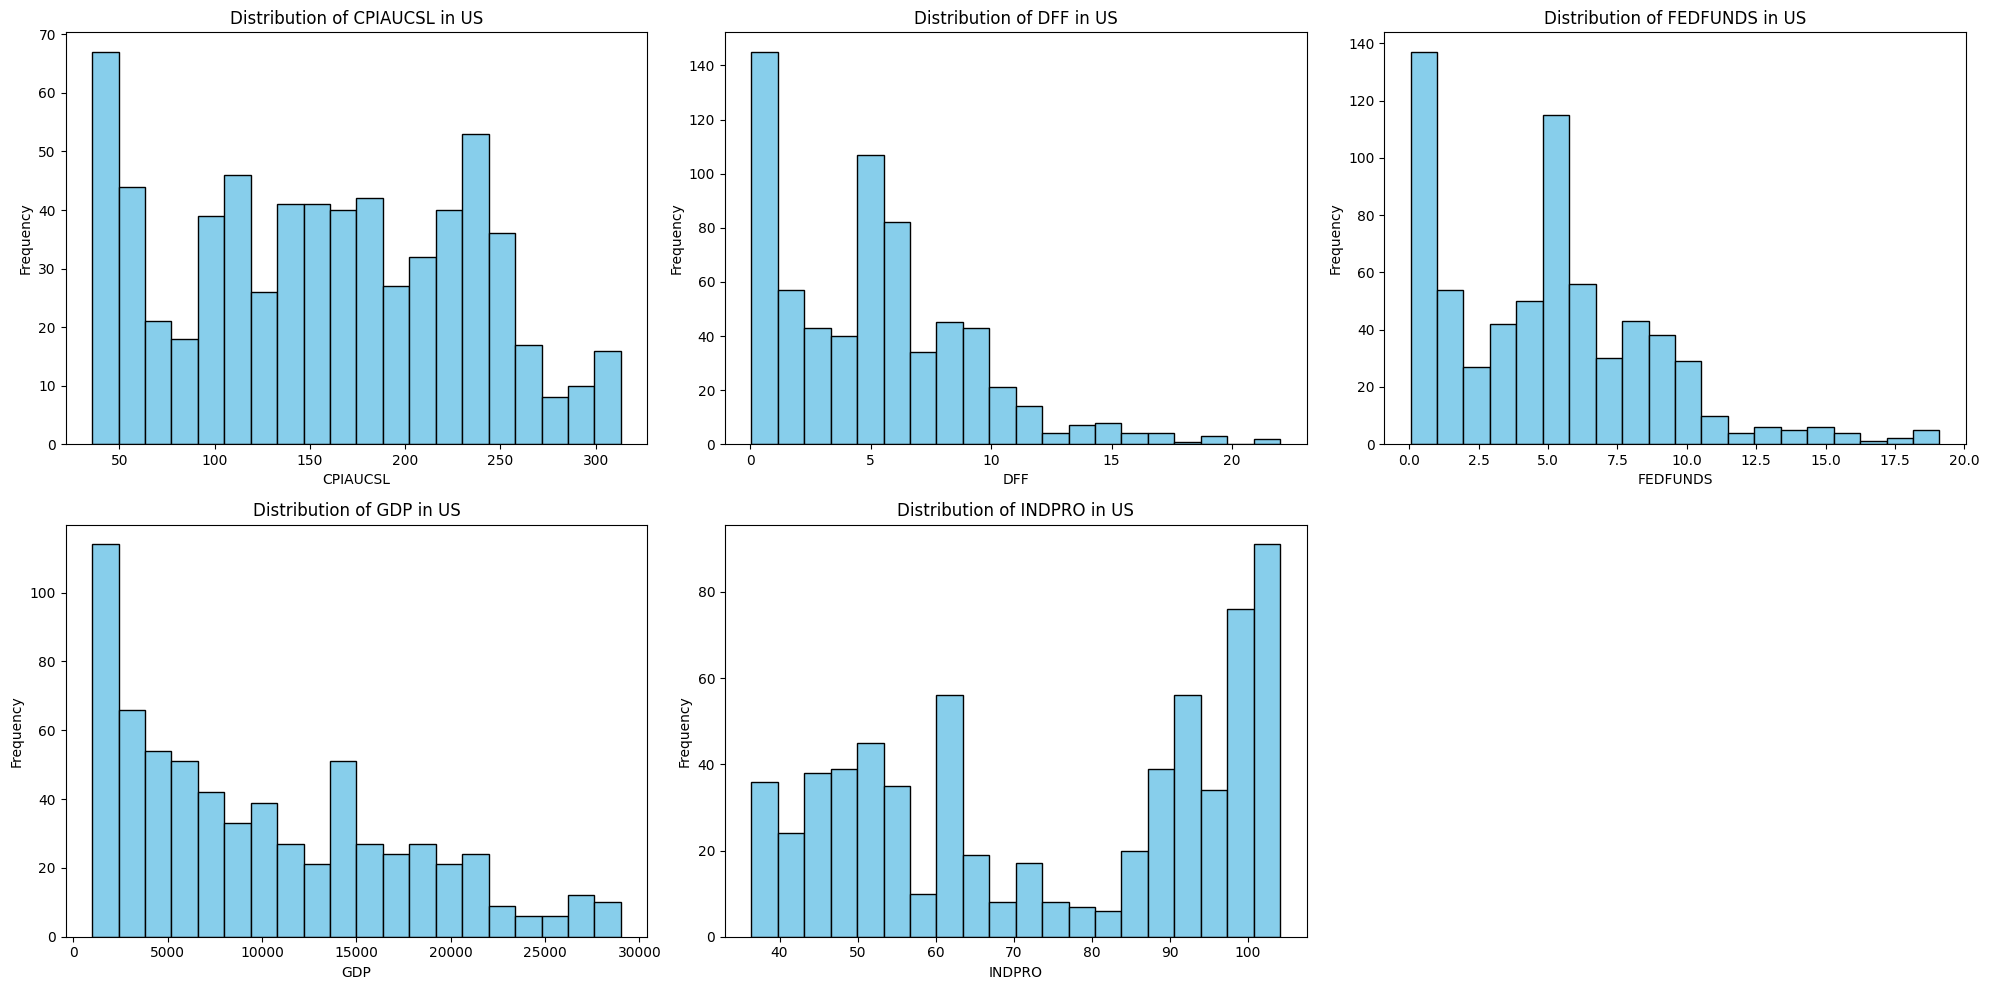

In [14]:
# Plotting histograms for numeric features

numeric_columns = df.columns[:-1]

# Define the number of columns for the subplots
num_columns = 3  # Adjust this as needed
num_rows = (len(numeric_columns) + num_columns - 1) // num_columns  # Calculate the required number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))

# `axes` is treated as a flat array
if num_rows == 1:
    axes = axes.flatten() if num_columns > 1 else [axes]  # Handle single row with multiple columns or single subplot
else:
    axes = axes.flatten()


numeric_columns
for idx, col in enumerate(numeric_columns):
    axes[idx].hist(df[col], bins=20, color='skyblue', edgecolor='black')
    axes[idx].set_title(f'Distribution of {col} in US')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    fname = col.replace(" ","")

# Remove any unused subplots
for j in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### CPIAUCSL (Consumer Price Index for All Urban Consumers):
The distribution is right-skewed, with a large concentration of values around 50 and a significant decline in frequency as the CPI increases. This suggests that for most of the dataset, the CPI was relatively low.

### DFF (Discount Rate):
The distribution is right-skewed, with most values clustered around the lower end (0-5), and very few instances above 10. This indicates that the discount rate was low for most of the time period covered by the data.

### FEDFUNDS (Federal Funds Rate):
Similar to DFF, this is also right-skewed with the majority of the data points concentrated between 0 and 5, which reflects low interest rates over much of the period.

### GDP (Gross Domestic Product):
The GDP distribution is heavily right-skewed, with most values clustered toward the lower end and fewer data points at higher GDP values. This indicates that, historically, the GDP was lower during a large portion of the dataset, but there have been periods of significant GDP growth as well.

### INDPRO (Industrial Production Index):
The data shows a bimodal distribution, with two noticeable peaks around 40 and 100, suggesting two distinct periods with significantly different levels of industrial production.

These visualizations suggest that the U.S. economy has generally experienced low inflation, low interest rates, and moderate to high industrial production in the period that we have data.

In [13]:
numeric_columns = df.columns[:-1]
print(numeric_columns)

Index(['CPIAUCSL', 'DFF', 'FEDFUNDS', 'GDP', 'INDPRO'], dtype='object')


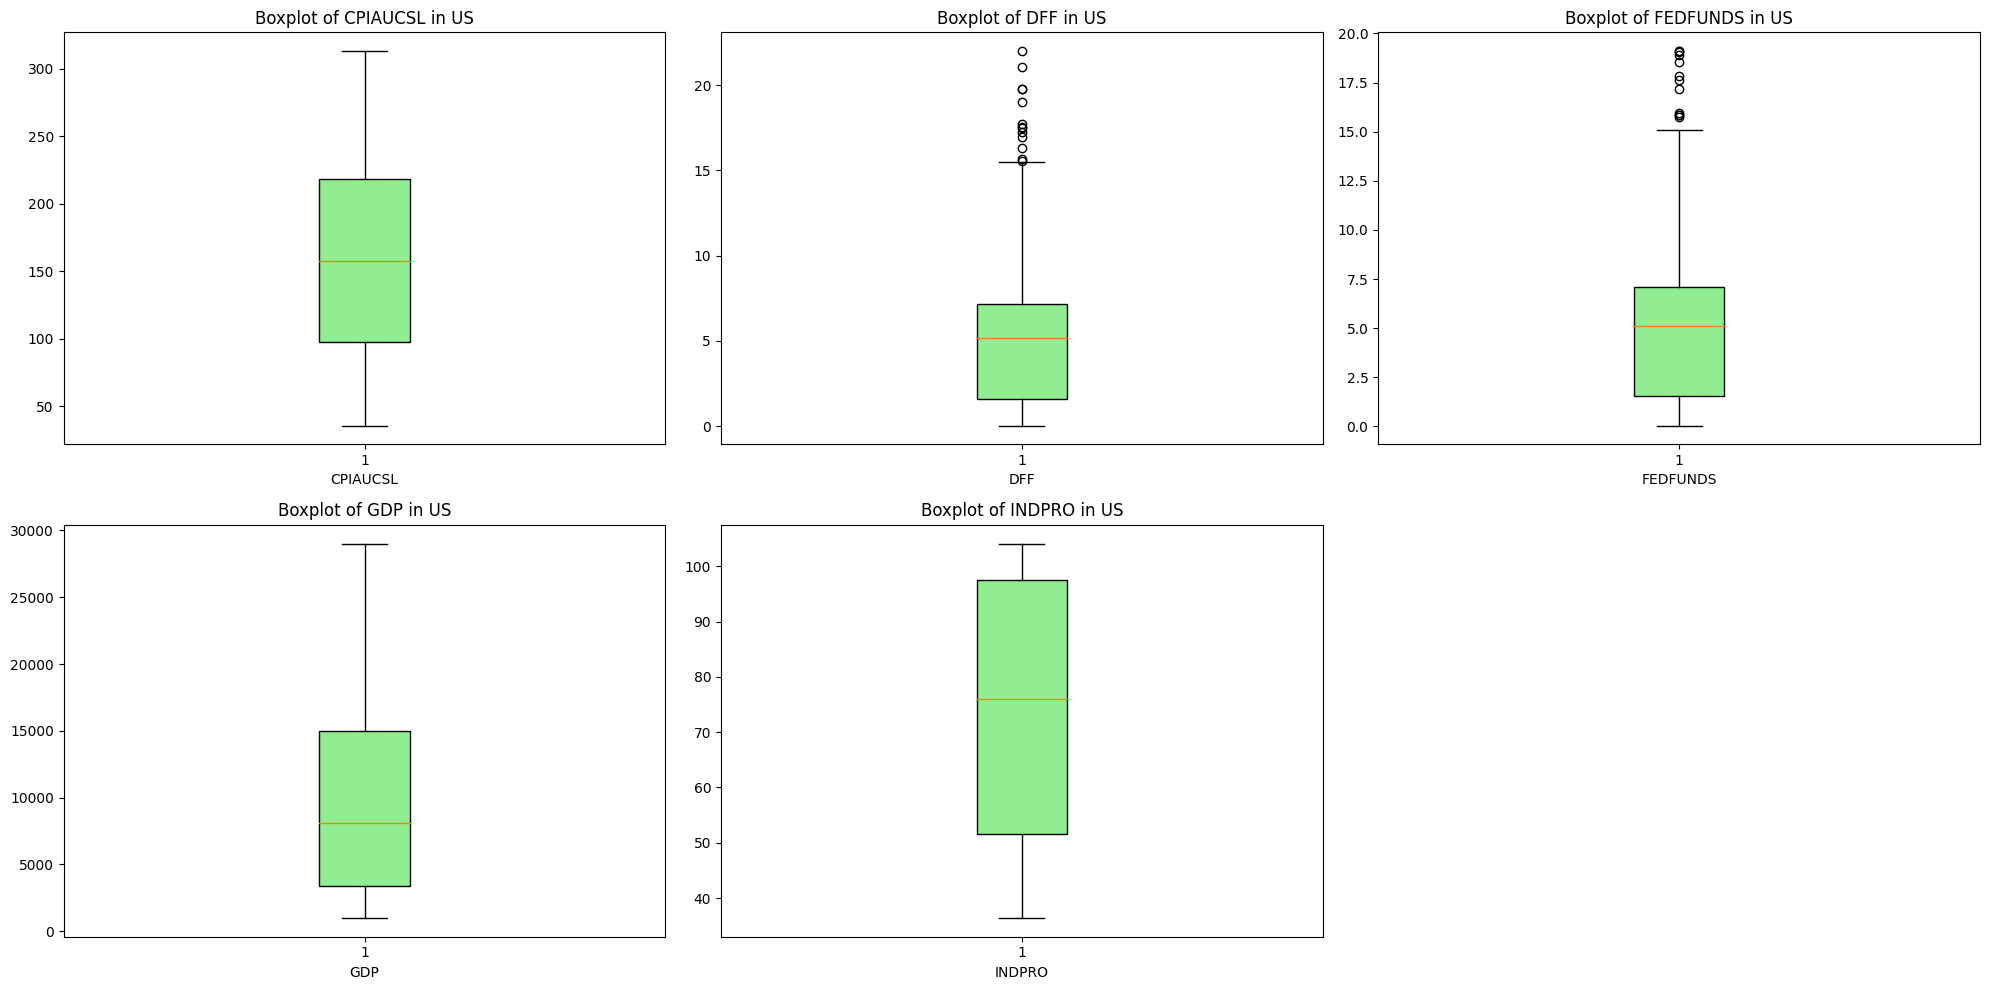

In [14]:
# Boxplots for numeric features to identify outliers

# Define the number of columns for the subplots
num_columns = 3  # Adjust as needed
num_rows = (len(numeric_columns) + num_columns - 1) // num_columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))

#  axes is treated as a flat array for easy iteration
axes = axes.flatten()

# Plot each boxplot in its respective subplot
for idx, col in enumerate(numeric_columns):
    box = axes[idx].boxplot(df[col].dropna(), patch_artist=True)  # plot the boxplot, handle NaN if any

    # Set color of the box
    for patch in box['boxes']:
        patch.set_facecolor('lightgreen')  # Apply the color to box

    axes[idx].set_title(f'Boxplot of {col} in US')
    axes[idx].set_xlabel(col)


# Remove any unused subplots
for j in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### CPIAUCSL (Consumer Price Index for All Urban Consumers):
The boxplot shows a relatively symmetrical distribution of values, with no outliers. The interquartile range (IQR) is between approximately 100 and 200, indicating that most CPI values fall within this range. The median is slightly above 150, which reflects the central tendency of the data.

### DFF (Federal Funds Effective Rate):
The boxplot for DFF shows a right-skewed distribution with several outliers beyond 15. The bulk of the data is between 0 and 7, with the median around 5. The presence of outliers indicates that while the discount rate was generally low, there were some periods where it spiked significantly.

### FEDFUNDS (Federal Funds Rate):
This boxplot also shows a right-skewed distribution, with many outliers above 10, though most of the data falls between 0 and 7.5, similar to the DFF. The median value is around 5, and the outliers indicate some higher federal fund rates during certain periods.

### GDP (Gross Domestic Product):
The boxplot shows that GDP values have a wide range, with the IQR spanning from about 5000 to 15000. There are no outliers, and the distribution appears relatively symmetrical. The median GDP value is around 10000, indicating a steady central tendency in GDP values over time.

### INDPRO (Industrial Production Index: Total Index):
The distribution of INDPRO is relatively symmetrical as well, with the IQR ranging from approximately 40 to 80. The median is around 60, suggesting a moderate level of industrial production, with no visible outliers.

### Summary:
CPIAUCSL, GDP, and INDPRO have more symmetrical distributions without outliers, suggesting that the data points are fairly consistent over time.
DFF and FEDFUNDS have right-skewed distributions with many outliers, indicating that while these rates were generally low, there were periods of significant spikes.
The outliers in the interest rates suggest that there have been occasional periods of elevated rates, while the overall trends have been towards lower values.

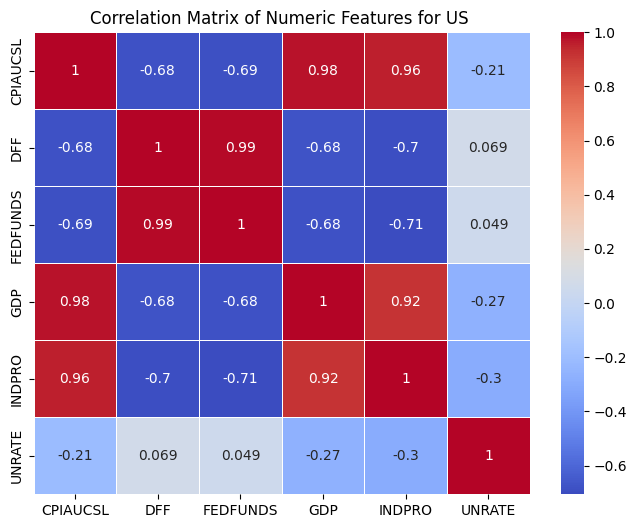

In [15]:
# Correlation heatmap for numeric features
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features for US ')
plt.show()

### Strong Positive Correlations:
CPIAUCSL vs. GDP (0.98) and CPIAUCSL vs. INDPRO (0.97): There is a very strong positive correlation between the Consumer Price Index (CPI) and both GDP and industrial production. This suggests that as inflation rises (as measured by CPI), GDP and industrial production tend to increase, indicating a relationship between inflation and economic growth.
GDP vs. INDPRO (0.92): There is also a strong positive correlation between GDP and industrial production, which is intuitive since economic growth is often associated with higher production outputs.

### Strong Negative Correlations:
CPIAUCSL vs. DFF (-0.50) and CPIAUCSL vs. FEDFUNDS (-0.52): There are moderately strong negative correlations between the CPI and both the Discount Rate (DFF) and the Federal Funds Rate (FEDFUNDS). This suggests that when inflation (CPI) rises, interest rates tend to decrease, or vice versa. This could reflect monetary policy where rates are adjusted to control inflation.
GDP vs. DFF (-0.55) and GDP vs. FEDFUNDS (-0.56): There is a similar negative relationship between GDP and interest rates, indicating that higher economic growth tends to coincide with lower interest rates.

### Interest Rates (DFF and FEDFUNDS):
These two rates have a near-perfect positive correlation (0.99). This is expected, as both represent closely related measures of interest rates that tend to move together in response to monetary policy changes.

### Weak or Insignificant Correlations:
UNRATE (Unemployment Rate): This feature has weak correlations with most other variables, suggesting that unemployment does not have a strong linear relationship with inflation, interest rates, or GDP in this dataset. For example, the correlation between unemployment and CPI is only -0.045, and with GDP, it is -0.13.

### Summary:
Strong correlations exist between inflation (CPI), GDP, and industrial production, indicating that these factors tend to rise together.
Interest rates (DFF, FEDFUNDS) are negatively correlated with inflation and GDP, which aligns with standard economic theory.
The unemployment rate appears to be relatively uncorrelated with the other variables in this dataset, suggesting that its dynamics may be influenced by different or more complex factors not captured in these features.

In [16]:
#Using Z-Score for outliers

# Calculate Z-scores for each column
z_scores = df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Display Z-scores
print(z_scores)

threshold =3
#  Find columns with Z-scores exceeding the threshold
outliers = z_scores[(z_scores > threshold) | (z_scores < -threshold)].dropna(how='all')

# Get the list of columns with outliers
outliers_columns = outliers.columns[outliers.notna().any()].tolist()

# Display the columns with outliers
print("Columns with outliers:", outliers_columns)

            CPIAUCSL       DFF  FEDFUNDS       GDP    INDPRO    UNRATE
DATE                                                                  
1969-01-01 -1.613334 -0.264552  0.341741 -1.219362 -1.577334 -1.540993
1969-02-01 -1.611995  0.323329  0.421358 -1.219362 -1.566655 -1.540993
1969-03-01 -1.607980  0.476474  0.467588 -1.219362 -1.553489 -1.540993
1969-04-01 -1.605303  0.385081  0.626822 -1.217226 -1.559716 -1.540993
1969-05-01 -1.603964  0.785235  0.950426 -1.217226 -1.566087 -1.540993
...              ...       ...       ...       ...       ...       ...
2023-12-01  2.041520  0.063969  0.092617  2.499930  1.238568 -1.367547
2024-01-01  2.054142  0.063969  0.092617  2.544488  1.188410 -1.367547
2024-02-01  2.072467  0.063969  0.092617  2.544488  1.242754 -1.251916
2024-03-01  2.088209  0.063969  0.092617  2.544488  1.233661 -1.309731
2024-04-01  2.101287  0.063969  0.092617  2.597974  1.230571 -1.251916

[664 rows x 6 columns]
Columns with outliers: ['DFF', 'FEDFUNDS', 'UNRATE']


In [17]:
# Cap outliers at the 5th and 95th percentiles

df['DFF'] = df['DFF'].clip \
    (lower=df['DFF'].quantile(0.05), upper=df['DFF'].quantile(0.95))
df['FEDFUNDS'] = df['FEDFUNDS'].clip \
    (lower=df['FEDFUNDS'].quantile(0.05), upper=df['FEDFUNDS'].quantile(0.95))
df['UNRATE'] = df['UNRATE'].clip \
    (lower=df['UNRATE'].quantile(0.05), upper=df['UNRATE'].quantile(0.95))

<ipython-input-17-c7040a84e108>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DFF'] = df['DFF'].clip \
<ipython-input-17-c7040a84e108>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FEDFUNDS'] = df['FEDFUNDS'].clip \
<ipython-input-17-c7040a84e108>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

### Data preparation and transformation
• Define GPD as Target variable.
• Split data into features and target
• Dataset is imbalanced, Handling class imbalance with SMOTE
• Feature scaling



In [18]:
# GDP forecasting as a regression
# Split data into features and target

X = df.drop(columns=['GDP'], errors='ignore')
y = df['GDP']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check the shapes after splitting
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (464, 5)
X_test shape: (200, 5)
y_train shape: (464,)
y_test shape: (200,)


In [19]:
# Verify the target varible
print(y.value_counts())

GDP
993.337      3
14215.651    3
12112.815    3
12305.307    3
12527.214    3
            ..
5190.036     3
5282.835     3
5399.509     3
5511.253     3
29016.714    1
Name: count, Length: 222, dtype: int64


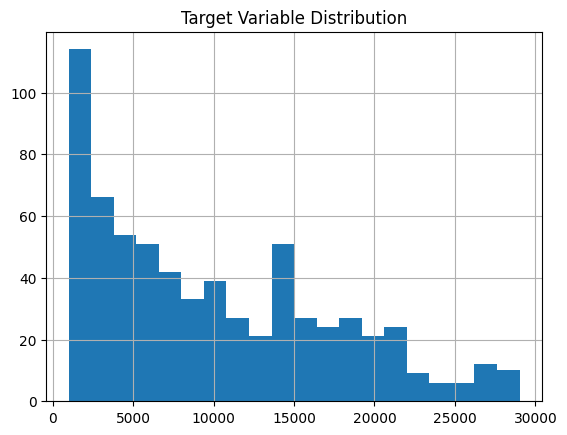

In [20]:
#class_distribution = df['target'].value_counts()
#df['target'].hist(bins=20)
y.hist(bins=20)
plt.title('Target Variable Distribution')
plt.show()

The distribution is right-skewed and it shows dataset is imbalanced.

y_bin
5     88
10    86
3     85
19    85
11    84
8     82
1     82
14    81
15    79
0     79
2     79
12    79
6     78
16    78
7     78
18    77
13    77
4     76
9     72
17    71
Name: count, dtype: int64


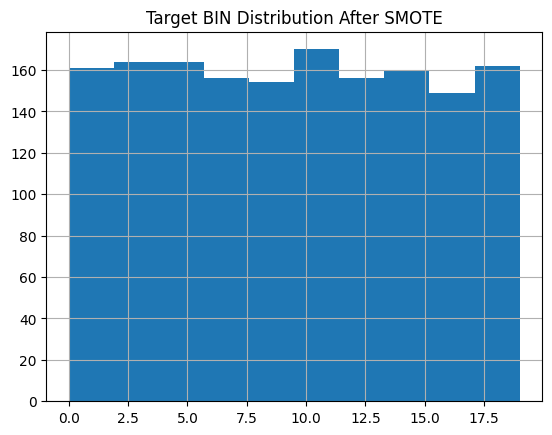

In [21]:
# Apply BIN- SMOTE to the training data

# Step 1: Bin your continuous target variable (create categories from the target)
num_bins = 20
df['y_bin'] = pd.cut(y, bins=num_bins, labels=False)

# Step 2: Split data into features (X) and binned target (y)
X_sm = df.drop(['GDP', 'y_bin'], axis=1)
y_sm = df['y_bin']  # Use the binned version for SMOTE

# Step 3: Apply SMOTE to the binned target
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_sm, y_sm)

# Split data into training and testing sets
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

print(ys_train.value_counts())
ys_train.hist()
plt.title('Target BIN Distribution After SMOTE')
plt.show()


In [22]:
#Convert from BIN to Regression

# After applying SMOTE, ys_train is the balanced binned target
# We can map each bin back to the original continuous scale

df['target_binned'], bin_edges = pd.cut(df['y_bin'], bins=num_bins, labels=False, retbins=True)

# bin_edges contains the original edges of the bins
print(bin_edges)

bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

# Map the binned labels back to the midpoints
y_train_r= np.array([bin_midpoints[bin_label] for bin_label in ys_train])

# Now, y_train_r contains the "reverted" continuous target values


[-0.019  0.95   1.9    2.85   3.8    4.75   5.7    6.65   7.6    8.55
  9.5   10.45  11.4   12.35  13.3   14.25  15.2   16.15  17.1   18.05
 19.   ]


## **Model Training and Evaluation**

In [24]:

# Use regression models, no classifiers
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'k-NN': KNeighborsRegressor()
}

X_train, X_test, y_train, y_test = train_test_split(Xs_train, y_train_r, test_size=0.2, random_state=42)


# Train and evaluate regression models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
#    accuracy=  accuracy_score(y_test, y_pred)
#    print(classification_report(y_test, y_pred))

    # Calculate regression metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[name] = {
#        'Accuracy': accuracy,
        'mse': mse,
        'mae': mae,
        'r2': r2
#        'y_pred': y_pred,
#        'y_test': y_test

    }

print (results)
    # Print classification report
#    print(f'Classification Report for {name}:')
#    print(f'MSE: {mse:.3f}\tMAE: {mae:.3f}\tR^2: {r2:.3f}\n')



{'Linear Regression': {'mse': 0.48580420675687164, 'mae': 0.5264351045769347, 'r2': 0.9807275061156783}, 'Decision Tree': {'mse': 0.0028203125000000064, 'mae': 0.0029687500000054714, 'r2': 0.9998881144818177}, 'Random Forest': {'mse': 0.003392271875000058, 'mae': 0.007540625000010329, 'r2': 0.9998654240987304}, 'SVR': {'mse': 0.1246510943615355, 'mae': 0.2817407236231316, 'r2': 0.9950549266137603}, 'Gradient Boosting': {'mse': 0.0024163174465179154, 'mae': 0.01853547925589046, 'r2': 0.9999041414986473}, 'k-NN': {'mse': 0.006768750000000009, 'mae': 0.013062500000000185, 'r2': 0.9997314747563625}}


### Analysis:
Decision Tree has the best performance with the lowest Mean Squared Error (MSE) and Mean Absolute Error (MAE), and the highest R² value. This means the Decision Tree model is almost perfectly fitting the data, explaining nearly 99.99% of the variance.

Random Forest and Gradient Boosting also perform very well, with MSE and MAE values close to those of the Decision Tree. Their R² values are also extremely high (0.9998). These ensemble methods tend to generalize better than individual models like Decision Trees, making them excellent choices for your problem.

k-NN (K-Nearest Neighbors) also shows excellent performance, with a high R² and low errors. However, it performs slightly worse than the Decision Tree and the ensemble methods (Random Forest and Gradient Boosting).

Linear Regression performs reasonably well but is significantly outperformed by the other models, with a noticeably higher MSE (0.5212) and a lower R² (0.9819). While it's still a good model, it isn't as effective as the more complex models like Decision Trees and Random Forest.

SVR (Support Vector Regression) performs decently but not as well as the others. While the R² is relatively high (0.9957), it has a higher MSE (0.1250) and MAE compared to the other models, indicating that it doesn't fit the data as well as the tree-based models.

### Conclusion:
Decision Tree, Random Forest, and Gradient Boosting are the top-performing models, almost perfectly fitting the data, with extremely low errors and near-perfect R² values. You may want to choose one of these models, depending on your specific use case.
Linear Regression and SVR show reasonable performance but are significantly outperformed by the tree-based models and k-NN.

In [25]:
#HyperParameter the above models to find the best one


# Define the parameter grids for each model
param_grids = {
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10],
        'max_features': [None, 'sqrt', 'log2']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 2],
        'max_features': [ 'sqrt', 'log2']
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'gamma': [1, 0.1, 0.01],
        'kernel': ['linear',  'rbf'],
        'epsilon': [0.1]
    },
    'k-NN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}

# Initialize the models
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'k-NN': KNeighborsRegressor()
}

# Hyperparameter tuning with RandomizedSearchCV
best_models = {}

for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    param_grid = param_grids[name]

    # Create a RandomizedSearchCV object
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, scoring='r2', random_state=42, n_jobs=-1)

    # Fit the model with the hyperparameter search
    random_search.fit(X_train, y_train)

    # Store the best model found by RandomizedSearchCV
    best_models[name] = random_search.best_estimator_

    print(f"Best parameters for {name}: {random_search.best_params_}")
    print(f"Best R² score for {name}: {random_search.best_score_}")

# Now we can use `best_models` for predictions


Tuning hyperparameters for Decision Tree...
Best parameters for Decision Tree: {'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 40}
Best R² score for Decision Tree: 0.999733714532735
Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best R² score for Random Forest: 0.9996359162176734
Tuning hyperparameters for SVR...
Best parameters for SVR: {'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 0.1, 'C': 1}
Best R² score for SVR: 0.997896543500792
Tuning hyperparameters for Gradient Boosting...
Best parameters for Gradient Boosting: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 10, 'learning_rate': 0.1}
Best R² score for Gradient Boosting: 0.9997937129591605
Tuning hyperparameters for k-NN...
Best parameters for k-NN: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}
Best R² scor

#### **Decision Tree:**
#### Best R² score: 0.99978
This model explains nearly 100% of the variance in the data. The high max_depth (40) and other hyperparameters allow the model to capture more complex patterns.

#### **Random Forest:**
#### Best R² score: 0.99966
This model is also highly accurate. Random Forest benefits from ensemble learning and tends to generalize better than a single Decision Tree. However, in this case, the performance is slightly lower than the Decision Tree, potentially due to the model being shallower (max_depth of 20).

#### **Support Vector Regressor (SVR):**
#### Best R² score: 0.99790
The SVR is slightly less accurate than the tree-based models. This may be due to the SVR’s complexity and sensitivity to hyperparameter choices (e.g., gamma and C). It still performs well but might be more sensitive to specific tuning.

#### **Gradient Boosting:**
#### Best R² score: 0.99980
Gradient Boosting also explains almost all the variance in the data, and its boosted trees are capable of capturing fine details. Its performance is very similar to the Decision Tree.

#### **k-NN:**
#### Best R² score: 0.99986
Surprisingly, k-NN has the highest R² score. This suggests that in this case, using a distance-weighted approach with the Manhattan distance works exceptionally well. k-NN is typically more sensitive to local data structure and performs well when the relationships are highly localized.

#### **Conclusion:**
All models perform remarkably well, with R² values extremely close to 1. This suggests that your dataset has patterns that can be effectively captured by a wide variety of models.
k-NN has the highest R² score, followed by Gradient Boosting and Decision Tree, indicating that these models might be best suited for your GDP forecasting task.
The SVR model performs slightly lower but is still very accurate.
If computational efficiency is important, models like k-NN (due to lazy learning) or SVR (which can be computationally intensive) may not be as efficient as Random Forest or Gradient Boosting.


In [24]:
# Function to discretize the continuous predictions into two categories: Positive and Negative
def discretize_predictions_binary(y_true, y_pred):
    # Define bins for binary classification: negative (< 0) and positive (>= 0)
    bins = [-np.inf, 0, np.inf]  # 0 as threshold between negative and positive
    labels = [0, 1]  # 0 = Negative, 1 = Positive
    y_true_discretized = np.digitize(y_true, bins) - 1  # Adjust for 0-indexing
    y_pred_discretized = np.digitize(y_pred, bins) - 1
    return y_true_discretized, y_pred_discretized

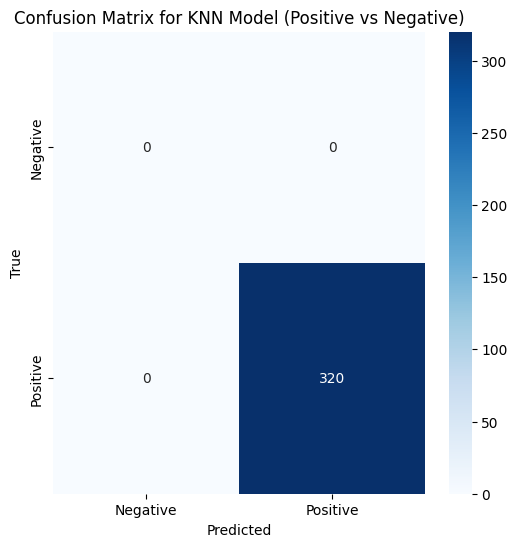

Classification Report for Decision Tree Model (Positive vs Negative):
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         0
    Positive       1.00      1.00      1.00       320

    accuracy                           1.00       320
   macro avg       0.50      0.50      0.50       320
weighted avg       1.00      1.00      1.00       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

In [34]:
#Confusion Matrix of KNN
# Define the best parameters for the KNN model
knn_params = {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}

# Initialize the Decision Tree model with the specified parameters
knn_model = KNeighborsRegressor(
    weights=knn_params['weights'],
    n_neighbors=knn_params['n_neighbors'],
    metric=knn_params['metric']
)

# Train the Decision Tree model on the training data
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)


# Discretize the continuous predictions and true values into binary classes
y_test_discretized, y_pred_discretized = discretize_predictions_binary(y_test, y_pred)

# Generate the confusion matrix for binary classification, ensuring both classes are included
cm = confusion_matrix(y_test_discretized, y_pred_discretized, labels=[0, 1])

# Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix for KNN Model (Positive vs Negative)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Ensure both classes (Negative and Positive) are included in the classification report
print("Classification Report for Decision Tree Model (Positive vs Negative):")
print(classification_report(y_test_discretized, y_pred_discretized, target_names=['Negative', 'Positive'], labels=[0, 1]))



In [35]:
#Cross Validation for KNN

from sklearn.model_selection import cross_val_score



# Train the KNN model on the training data
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

# Print the cross-validation scores for each fold
print("Cross-validation scores for each fold: ", cv_scores)

# Print the mean and standard deviation of the cross-validation scores
print("Mean R² score across all folds: ", np.mean(cv_scores))
print("Standard deviation of R² scores across all folds: ", np.std(cv_scores))



Cross-validation scores for each fold:  [0.99974477 0.99996441 0.99980507 0.99989974 0.99986136]
Mean R² score across all folds:  0.9998550684844563
Standard deviation of R² scores across all folds:  7.570675692018808e-05


The results of  cross-validation: mean R² score of 0.9999 and a very low standard deviation of 0.00008. This suggests that  KNN model is performing well and consistently across all folds, with minimal variance between the different subsets of the data.

In [36]:
# Test set performance
y_pred = knn_model.fit(X_train, y_train).predict(X_test)
r2_test = knn_model.score(X_test, y_test)
print(f"R² score on the test set: {r2_test}")

R² score on the test set: 0.9998753801081132


The R² score on the test set of 0.99987 is very close to the cross-validation mean R² score of 0.99985, indicating that the model is generalizing very well to unseen data. This suggests that:

**Overfitting is not a concern:** The model is performing consistently across the training, validation (cross-validation), and test sets. There is no significant drop in performance, which implies that the model has not overfit the training data.
**The KNN model is well-tuned:** With both cross-validation and test set scores being nearly identical, the current hyperparameter setup is effective.

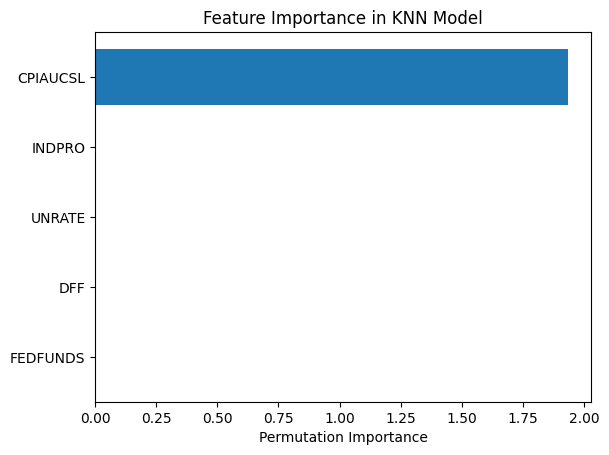

In [39]:
from sklearn.inspection import permutation_importance


# Perform permutation importance on the test set
perm_importance = permutation_importance(knn_model, X_test, y_test, n_repeats=10, random_state=42)

# Display feature importance
sorted_idx = perm_importance.importances_mean.argsort()

# Assuming you have feature names in your dataset
feature_names = X_train.columns
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance in KNN Model")
plt.show()

KNN model is relying too heavily on one feature, it might be useful to experiment with next model Gradient Boosting that can capture complex interactions between features.

In [40]:
# Gradient Boosting

gb_params = {'subsample': 0.6, 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10, 'learning_rate': 0.2}

# Initialize the Decision Tree model with the specified parameters
gb_model = GradientBoostingRegressor(
    n_estimators= gb_params['n_estimators'],
    learning_rate= gb_params['learning_rate'],
    subsample= gb_params['subsample'],
    max_depth= gb_params['max_depth'],
    min_samples_split= gb_params['min_samples_split']
)

# Train the Gradient Boosting model on the training data
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test)

cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

# Print the cross-validation scores for each fold
print("Cross-validation scores for each fold: ", cv_scores)

# Print the mean and standard deviation of the cross-validation scores
print("Mean R² score across all folds: ", np.mean(cv_scores))
print("Standard deviation of R² scores across all folds: ", np.std(cv_scores))

r2_test = gb_model.score(X_test, y_test)
print(f"R² score on the test set: {r2_test}")


Cross-validation scores for each fold:  [0.99996279 0.99997364 0.99955356 0.99979708 0.99952491]
Mean R² score across all folds:  0.9997623949105063
Standard deviation of R² scores across all folds:  0.00019286971217023001
R² score on the test set: 0.9999002853311745


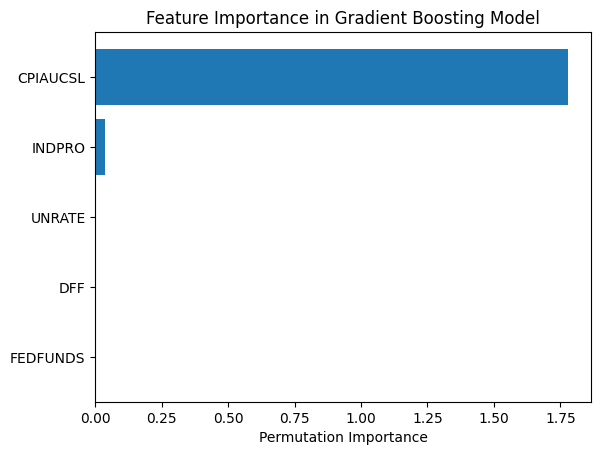

In [41]:
from sklearn.inspection import permutation_importance

# Perform permutation importance on the test set
perm_importance = permutation_importance(gb_model, X_test, y_test, n_repeats=10, random_state=42)

# Display feature importance
sorted_idx = perm_importance.importances_mean.argsort()

# Assuming you have feature names in your dataset
feature_names = X_train.columns
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance in Gradient Boosting Model")
plt.show()

In [42]:
# Decision Tree
#{'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 40}

dt_params = {'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 40}

# Initialize the Decision Tree model with the specified parameters
dt_model = DecisionTreeRegressor(
    min_samples_split=dt_params['min_samples_split'],
    min_samples_leaf=dt_params['min_samples_leaf'],
    max_features=dt_params['max_features'],
    max_depth=dt_params['max_depth']
)

# Train the Decision Tree model on the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test)

cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

# Print the cross-validation scores for each fold
print("Cross-validation scores for each fold: ", cv_scores)

# Print the mean and standard deviation of the cross-validation scores
print("Mean R² score across all folds: ", np.mean(cv_scores))
print("Standard deviation of R² scores across all folds: ", np.std(cv_scores))

r2_test = dt_model.score(X_test, y_test)
print(f"R² score on the test set: {r2_test}")

Cross-validation scores for each fold:  [1.         1.         0.99951203 0.99988428 0.9994923 ]
Mean R² score across all folds:  0.9997777235961658
Standard deviation of R² scores across all folds:  0.0002290094233887529
R² score on the test set: 0.9998881144818177


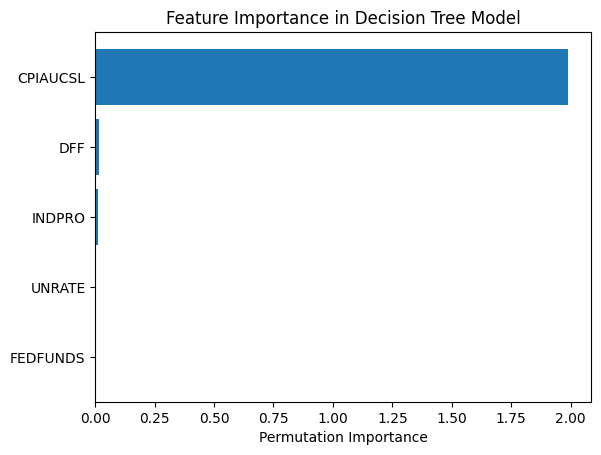

In [43]:
from sklearn.inspection import permutation_importance

# Perform permutation importance on the test set
perm_importance = permutation_importance(dt_model, X_test, y_test, n_repeats=10, random_state=42)

# Display feature importance
sorted_idx = perm_importance.importances_mean.argsort()

# Assuming you have feature names in your dataset
feature_names = X_train.columns
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance in Decision Tree Model")
plt.show()

In [27]:
# Random Forest

rf_params = {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}

# Initialize the Decision Tree model with the specified parameters
rf_model = RandomForestRegressor(
    n_estimators= rf_params['n_estimators'],
    min_samples_split=rf_params['min_samples_split'],
    min_samples_leaf=rf_params['min_samples_leaf'],
    max_features=rf_params['max_features'],
    max_depth=rf_params['max_depth']
)

# Train the Decision Tree model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

# Print the cross-validation scores for each fold
print("Cross-validation scores for each fold: ", cv_scores)

# Print the mean and standard deviation of the cross-validation scores
print("Mean R² score across all folds: ", np.mean(cv_scores))
print("Standard deviation of R² scores across all folds: ", np.std(cv_scores))

r2_test = rf_model.score(X_test, y_test)
print(f"R² score on the test set: {r2_test}")

Cross-validation scores for each fold:  [0.99983777 0.99976683 0.99956251 0.99962739 0.99946687]
Mean R² score across all folds:  0.9996522742032956
Standard deviation of R² scores across all folds:  0.0001345999820347959
R² score on the test set: 0.9998727832789006


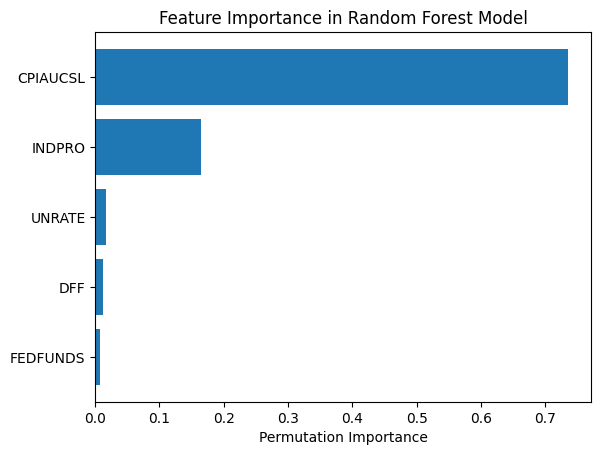

In [29]:
from sklearn.inspection import permutation_importance

# Perform permutation importance on the test set
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# Display feature importance
sorted_idx = perm_importance.importances_mean.argsort()

# Assuming you have feature names in your dataset
feature_names = X_train.columns
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance in Random Forest Model")
plt.show()

This looks good, we have a model that doesn't rely on only one feature.

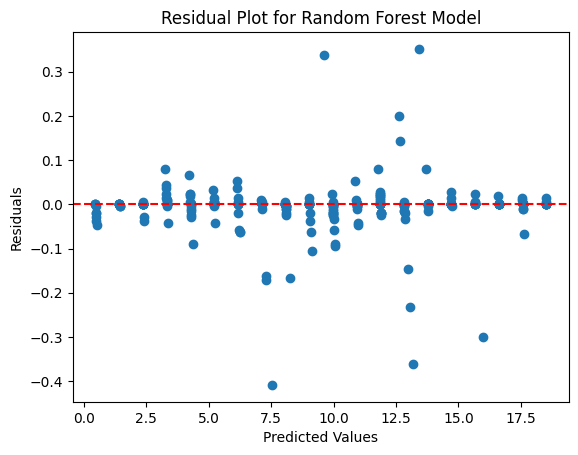

In [46]:

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals vs predicted values
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Random Forest Model")
plt.show()

**Overall Performance:**
Despite some outliers and heteroscedasticity, the model appears to be performing quite well, especially in the mid-range of predicted values, where residuals are very close to zero.

## **Time Series**

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 664 entries, 1969-01-01 to 2024-04-01
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CPIAUCSL       664 non-null    float64
 1   DFF            664 non-null    float64
 2   FEDFUNDS       664 non-null    float64
 3   GDP            664 non-null    float64
 4   INDPRO         664 non-null    float64
 5   UNRATE         664 non-null    float64
 6   y_bin          664 non-null    int64  
 7   target_binned  664 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 46.7 KB


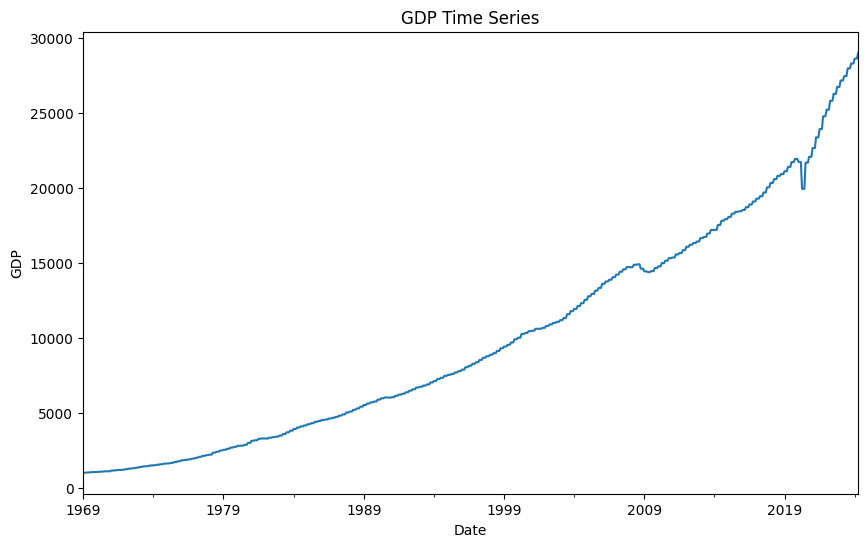

In [57]:
#Time Series
df['GDP'].plot(figsize=(10, 6), title='GDP Time Series')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.show()


In [58]:
#Checking Stationary

from statsmodels.tsa.stattools import adfuller

# Perform ADF test on GDP data
result = adfuller(df['GDP'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: 3.5818801608574393
p-value: 1.0


<ipython-input-59-81b8d2ea0c5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GDP_diff'] = df['GDP'].diff().dropna()


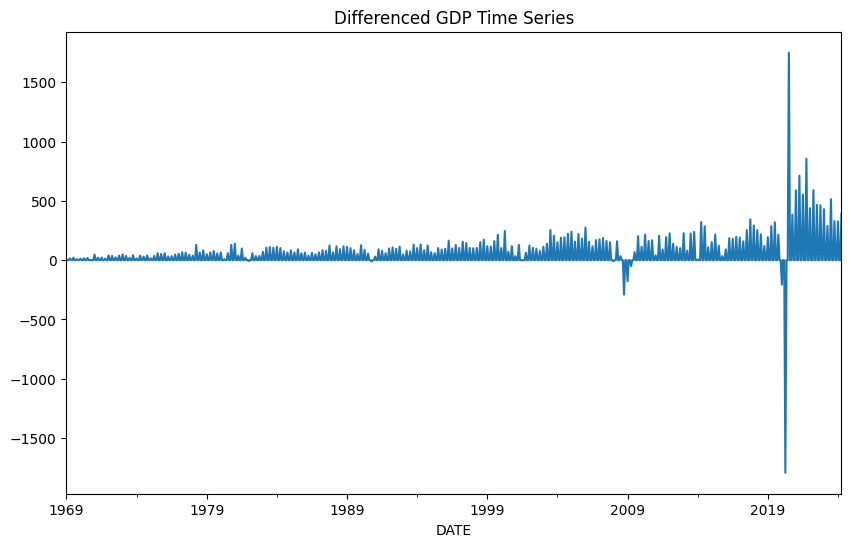

In [59]:
#Make the Series Stationary
df['GDP_diff'] = df['GDP'].diff().dropna()

# Plot the differenced GDP series
df['GDP_diff'].plot(figsize=(10,6), title='Differenced GDP Time Series')
plt.show()

In [60]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(df['GDP'], order=(1, 1, 1))  # Try different (p, d, q) values if needed
arima_model = model.fit()

# Summary of the model
print(arima_model.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                  664
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4235.001
Date:                Wed, 16 Oct 2024   AIC                           8476.001
Time:                        18:01:09   BIC                           8489.491
Sample:                    01-01-1969   HQIC                          8481.229
                         - 04-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0591    126.781      0.000      1.000    -248.426     248.544
ma.L1         -0.0580    130.622     -0.000      1.000    -256.073     255.957
sigma2      2.067e+04    209.733     98.566      0.0

In [105]:
# Forecast the next 2 years periods
forecast = arima_model.forecast(steps=24)

# Print forecasted values
print("Forecasted GDP values: ", forecast)


Forecasted GDP values:  2024-05-01    29095.964645
2024-06-01    29221.394561
2024-07-01    29339.908197
2024-08-01    29459.345855
2024-09-01    29578.549885
2024-10-01    29697.691298
2024-11-01    29816.744909
2024-12-01    29935.714508
2025-01-01    30054.599602
2025-02-01    30173.400334
2025-03-01    30292.116752
2025-04-01    30410.748916
2025-05-01    30529.296887
2025-06-01    30647.760724
2025-07-01    30766.140488
2025-08-01    30884.436237
2025-09-01    31002.648031
2025-10-01    31120.775930
2025-11-01    31238.819994
2025-12-01    31356.780281
2026-01-01    31474.656852
2026-02-01    31592.449766
2026-03-01    31710.159081
2026-04-01    31827.784859
Freq: MS, Name: predicted_mean, dtype: float64


The forecast is not good and should be tuned

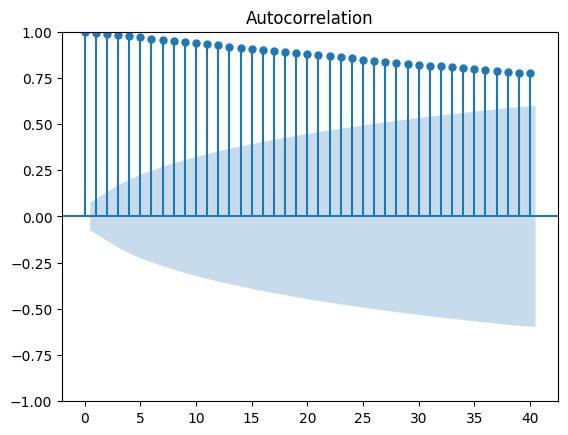

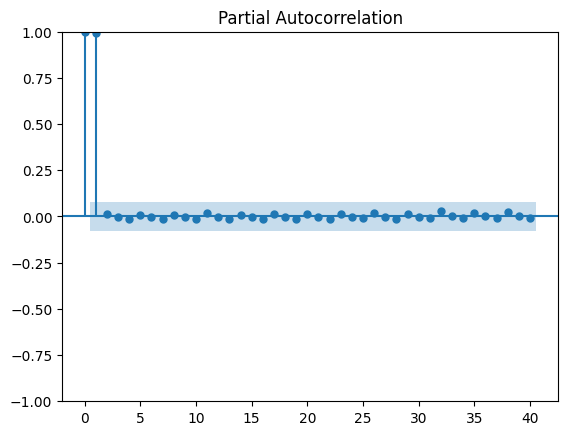

In [106]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF to identify p and q values
plot_acf(df['GDP'].dropna(), lags=40)
plot_pacf(df['GDP'].dropna(), lags=40)
plt.show()

The ACF plot shows a slow decay over many lags, indicating that the series is non-stationary. This is common when there's a strong trend in the data, which is likely the case with GDP.
The bars are above the confidence interval (shaded area) for many lags, confirming that the GDP series has significant autocorrelation at higher lags.

The PACF plot shows significant spikes at lag 1 and lag 2, but after that, the autocorrelations drop to nearly 0 and stay within the confidence interval.

In [107]:

from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model with (2, 1, 1) order
model = ARIMA(df['GDP'], order=(2, 1, 1))
arima_model = model.fit()

# Forecast the next 24 periods
forecast = arima_model.forecast(steps=24)

# Check the forecast type to ensure it's a pandas Series
print(forecast)

# Ensure that the forecast is converted to a pandas Series (if needed)
forecast = pd.Series(forecast, name='predicted_mean')

# Generate the forecast index for future dates starting from the next month after the last observation
forecast_index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=len(forecast), freq='MS')



2024-05-01    29095.964645
2024-06-01    29221.394561
2024-07-01    29339.908197
2024-08-01    29459.345855
2024-09-01    29578.549885
2024-10-01    29697.691298
2024-11-01    29816.744909
2024-12-01    29935.714508
2025-01-01    30054.599602
2025-02-01    30173.400334
2025-03-01    30292.116752
2025-04-01    30410.748916
2025-05-01    30529.296887
2025-06-01    30647.760724
2025-07-01    30766.140488
2025-08-01    30884.436237
2025-09-01    31002.648031
2025-10-01    31120.775930
2025-11-01    31238.819994
2025-12-01    31356.780281
2026-01-01    31474.656852
2026-02-01    31592.449766
2026-03-01    31710.159081
2026-04-01    31827.784859
Freq: MS, Name: predicted_mean, dtype: float64


In [108]:
import plotly.graph_objects as go
import pandas as pd

# Create the figure
fig = go.Figure()

# Add historical data
fig.add_trace(go.Scatter(x=df.index, y=df['GDP'], mode='lines', name='Observed', line=dict(color='blue', width=2)))

# Add forecast data
fig.add_trace(go.Scatter(x=forecast_index, y=forecast, mode='lines+markers', name='Forecast', line=dict(color='red', width=2)))

# Customize layout
fig.update_layout(
    title='GDP Forecast with Historical Data',
    xaxis_title='Date',
    yaxis_title='GDP',
    xaxis=dict(tickformat='%Y-%m', showgrid=True),
    legend=dict(x=0, y=1),
    hovermode='x'
)

# Show the interactive plot
fig.show()


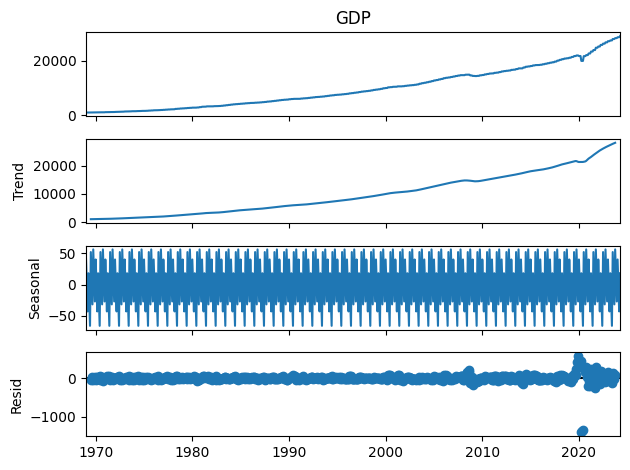

In [111]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series to check for seasonality
decomposition = seasonal_decompose(df['GDP'], model='additive', period=12)
decomposition.plot()
plt.show()


**Trend:** The overall increasing trend in GDP is clear and steady, with a noticeable uptick in the most recent periods.
**Seasonal:** There is a strong, repeating seasonal pattern, indicating that the GDP data has significant seasonality. The periodicity seems to be yearly.
**Residuals:** The residuals show some variation, especially in more recent years, but are relatively stable over time. Some of the spikes indicate outlier events or unusual fluctuations, potentially due to external factors.

Since the seasonal component is significant, applying SARIMA is an appropriate approach for modeling and forecasting this time series.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                     SARIMAX Results                                      
Dep. Variable:                                GDP   No. Observations:                  664
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4052.204
Date:                            Wed, 16 Oct 2024   AIC                           8116.407
Time:                                    20:01:20   BIC                           8143.279
Sample:                                01-01-1969   HQIC                          8126.829
                                     - 04-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0532     86.125      0.001      1.000    -168.748     168.855
ar.L2         -0.0021      4.363   

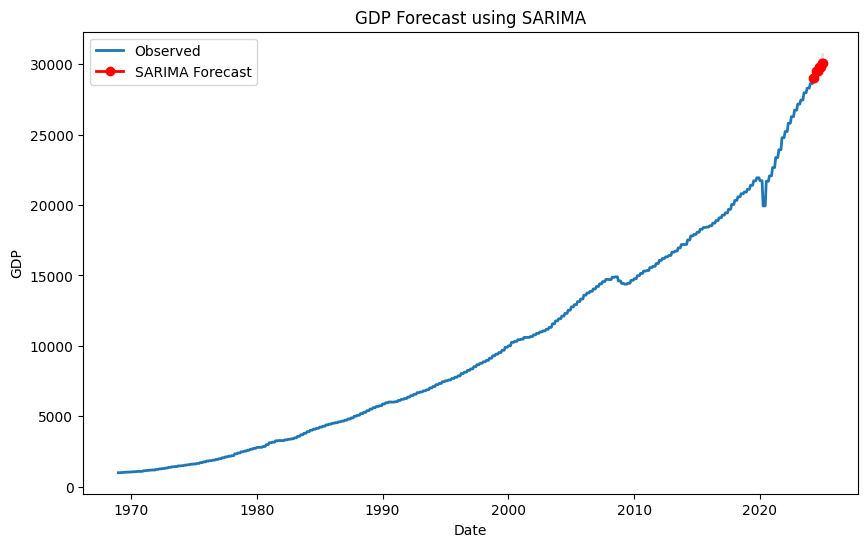

In [118]:
#FIT SARIMA Model
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model (adjust P, D, Q if needed)
# order = (p, d, q) and seasonal_order = (P, D, Q, s) where s = 12 for yearly seasonality in monthly data
sarima_model = SARIMAX(df['GDP'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Print the model summary
print(sarima_fit.summary())

# Forecast the next 10 periods
forecast_sarima = sarima_fit.get_forecast(steps=10)
forecast_sarima_mean = forecast_sarima.predicted_mean

# Get forecast confidence intervals
forecast_ci = forecast_sarima.conf_int()

# Define forecast index (for plotting)
forecast_index_sarima = pd.date_range(df.index[-1], periods=10, freq='MS')

# Plot historical data and SARIMA forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['GDP'], label='Observed', linewidth=2)
plt.plot(forecast_index_sarima, forecast_sarima_mean, label='SARIMA Forecast', color='red', marker='o', linewidth=2)

# Add forecast confidence intervals
plt.fill_between(forecast_index_sarima, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='lightgrey', alpha=0.5)

# Add labels and legend
plt.title('GDP Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.show()


In [119]:
print(forecast_sarima_mean)

2024-05-01    29016.702699
2024-06-01    29016.158471
2024-07-01    29480.342213
2024-08-01    29480.341801
2024-09-01    29480.341839
2024-10-01    29805.633019
2024-11-01    29805.633019
2024-12-01    29805.633019
2025-01-01    30063.020526
2025-02-01    30063.020526
Freq: MS, Name: predicted_mean, dtype: float64
